## Подготовка датасета


Описание датасета

A Dataset With Over 100,000 Face Images of 530 People
Large face datasets are important for advancing face recognition research, but they are tedious to build, because a lot of work has to go into cleaning the huge amount of raw data. To facilitate this task, we developed an approach to building face datasets that detects faces in images returned from searches for public figures on the Internet, followed by automatically discarding those not belonging to each queried person.

The FaceScrub dataset was created using this approach, followed by manually checking and cleaning the results. It comprises a total of 106,863 face images* of male and female 530 celebrities, with about 200 images per person. As such, it is one of the largest public face databases. The dataset was also used as part of the MegaFace face recognition challenges.

The images were retrieved from the Internet and are taken under real-world situations (uncontrolled conditions). Name and gender annotations of the faces are included.


| FaceScrub	|Male |	Female |	Total|
|----------|------|--------|---------|
|people:	|265 |	265	| 530 |
|images:	|55,306 |	51,557 |	106,863|

### MegaFace challenge

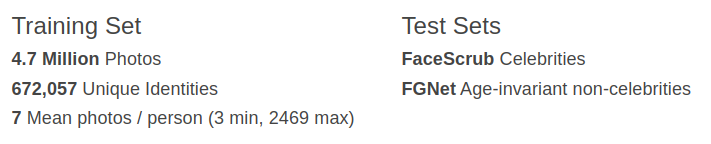

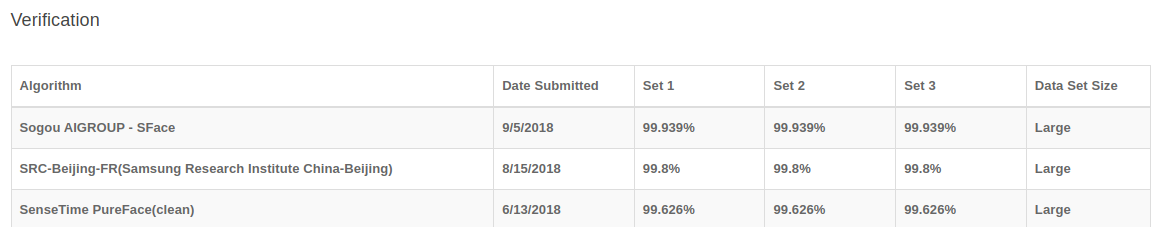

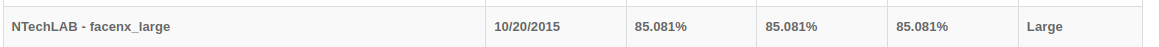

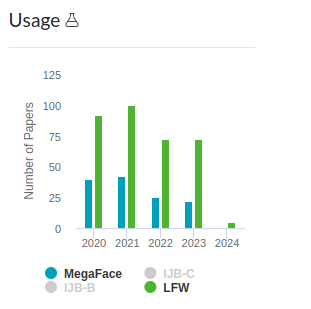

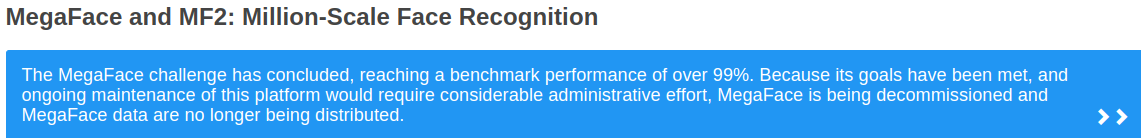

#### Импорт модулей

In [1]:
import pandas as pd
from deepface import DeepFace
from typing import List, Tuple
import numpy as np
import os
import cv2

/tmp/ipykernel_125893/2461289039.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-29 15:28:33.384873: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 15:28:33.412323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 15:2

#### Путь к датасету

In [2]:
dataset_path = '../datasets/facescrub_images/'

#### Функция для парсинга файлов-изображений

In [3]:
def list_images(path):
    """Create default dict with img paths"""
    imgs_list = []
    for dir in os.listdir(path):
        full_path = os.path.join(path, dir)
        for img_name in os.listdir(full_path):
            img_path = os.path.join(full_path, img_name)         
            if img_path.endswith('.png') or img_path.endswith('.jpg') or img_path.endswith('.jpeg') :
                imgs_list.append((img_path, dir, img_name))
    return imgs_list

#### Сохраним пути к изображениям в список

In [4]:
imgs_list = list_images(dataset_path)

#### Преобразуем список в датафрейм

In [5]:
imgs_df = pd.DataFrame(imgs_list, columns=['img_path', 'name', 'img_name'])
imgs_df.head()

,img_path,name,img_name
0,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34645.png
1,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34540.png
2,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34523.png
3,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34537.png
4,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34545.png


#### Посчитаем статистику датасета

In [6]:
grouped_df = imgs_df.groupby(['name'])['name'].agg('count')
print("Количество всего изображений:", imgs_df.shape[0])
print("Среднее количество изображений на одного человека:", int(grouped_df.mean()))
print("Минимальное количество изображений на одного человека:", int(grouped_df.min()))
print("Максимальное количество изображений на одного человека:", int(grouped_df.max()))
print("Количество уникальных людей:", int(grouped_df.shape[0]))

Количество всего изображений: 3530
Среднее количество изображений на одного человека: 44
Минимальное количество изображений на одного человека: 27
Максимальное количество изображений на одного человека: 50
Количество уникальных людей: 80


#### Разделение датасета на две выборки: распологаемую в БД и тестовую

In [7]:
IMGS_IN_DB_COUNT = 3

imgs_df['obj_row'] = imgs_df.groupby(['name']).cumcount() + 1
imgs_df.head()

,img_path,name,img_name,obj_row
0,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34645.png,1
1,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34540.png,2
2,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34523.png,3
3,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34537.png,4
4,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34545.png,5


In [8]:
def split_dataset(df: pd.DataFrame, db_count: int) -> Tuple[pd.DataFrame]:
    """Split init df to db and test dfs

    Args:
        df (pd.DataFrame): initial df
        db_count (int): how many object per person should be in DB

    Returns:
        Tuple[pd.DataFrame]: db_df, test_df
    """    
    imgs_db_df = df[df['obj_row'] <= db_count]
    imgs_test_df = df[df['obj_row'] > db_count]
    return imgs_db_df, imgs_test_df

In [9]:
imgs_db_df, imgs_test_df = split_dataset(imgs_df, IMGS_IN_DB_COUNT)
imgs_db_df.head()

,img_path,name,img_name,obj_row
0,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34645.png,1
1,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34540.png,2
2,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34523.png,3
46,../datasets/facescrub_images/Brianna_Brown/Bri...,Brianna_Brown,Brianna_Brown_10402.png,1
47,../datasets/facescrub_images/Brianna_Brown/Bri...,Brianna_Brown,Brianna_Brown_10441.png,2


### Создание эмбеддингов изображений

In [10]:
RECOGNITION_MODEL = 'ArcFace'
DETECT_MODEL = 'opencv'

In [11]:
def get_emb_list_from_df(img_df: pd.DataFrame, embedding_model, backend_model) -> list:
    emb_list = []
    errors_list = []
    for path, name, img_name, row in img_df.values:
        try:
            faces_obj = DeepFace.represent(path, model_name=embedding_model, detector_backend=backend_model)
            embedding = np.array(faces_obj[0]['embedding'])
            emb_list.append((name, img_name, path, embedding))
        except:
            print("Can't detect face", name, row)
            errors_list.append((name, path, row))
        
    return emb_list, errors_list

In [12]:
imgs_db_embeddings, errors_list = get_emb_list_from_df(imgs_db_df, embedding_model=RECOGNITION_MODEL, backend_model=DETECT_MODEL)
print(f'На векторизацию отправлено {imgs_db_df.shape[0]} изображений. Изображений, где не обнаружены лица: {len(errors_list)} ')

2024-02-29 15:29:01.412855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 15:29:01.440374: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Can't detect face Adrienne_Barbeau 1
Can't detect face J.K._Simmons 1
Can't detect face Geoffrey_Rush 3
Can't detect face Patrick_Swayze 3
Can't detect face Didi_Conn 3
Can't detect face Robert_Redford 1
Can't detect face Farrah_Fawcett 3
На векторизацию отправлено 240 изображений. Изображений, где не обнаружены лица: 7 


#### Количество изображений, которые не попали в БД по каждому объекту:

In [13]:
from collections import Counter

names = [name for name, path, row in errors_list]

counts = Counter(names)
error_names = [name for name, err_count in counts.items() if err_count >= IMGS_IN_DB_COUNT]
error_names

[]

#### Чистим тестовый датасет от людей, лица которых не удалось распознать при загрузке в БД

In [15]:
cleaned_test_df = imgs_test_df[~imgs_test_df['name'].isin(error_names)]
cleaned_test_df.head()

,img_path,name,img_name,obj_row
3,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34537.png,4
4,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34545.png,5
5,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34557.png,6
6,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34550.png,7
7,../datasets/facescrub_images/Marilu_Henner/Mar...,Marilu_Henner,Marilu_Henner_34512.png,8


### Загружаем выборку в БД

In [16]:
import psycopg2 as pg
from environs import Env


env = Env()
env.read_env('../.env', recurse=False)
conn=pg.connect(
    dbname='maska',
      user='postgres',
        password= env.str('PSQL_PASSWORD'),
          host='localhost',
          port='5432' )
cursor = conn.cursor()

#### Количество измерений на выходе модели

In [18]:
vector_size = 512

#### Создание таблицы

In [19]:
table_name = 'faces_test'
cursor.execute(f"DROP TABLE IF EXISTS {table_name}")
cursor.execute(f"CREATE TABLE IF NOT EXISTS {table_name} (id bigserial PRIMARY KEY, name varchar(30), img_name varchar(50), img_path text, embedding vector({vector_size}))")
conn.commit()

#### Запись значений в БД

In [20]:
for name, img_name, path, embedding in imgs_db_embeddings:        
    embedding = list(embedding)
    cursor.execute(f"INSERT INTO faces_test (name, img_name, img_path, embedding) VALUES (%s, %s, %s, %s)", (name, img_name, path, embedding))
    conn.commit()    

In [21]:
print(f"В БД загружено {len(imgs_db_embeddings)} изображений")

В БД загружено 233 изображений


#### Скопируем тестовые изображения и изображения находящтеся в БД в определенную папку

Удалим старые изображения

In [22]:
import shutil, os

test_folder = '../datasets/model_test/test'
database_folder = '../datasets/model_test/database'


def delete_dir_content(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
delete_dir_content(test_folder)
delete_dir_content(database_folder)

In [23]:
test_images = [path for path, name, img_name, row in imgs_test_df.values]
test_images
for f in test_images:
    shutil.copy(f, test_folder)

In [24]:
db_images = [path for path, name, img_name, row in imgs_db_df.values]
db_images
for f in db_images:
    shutil.copy(f, database_folder)

## Предсказываем людей по тестовым фото, сравнивая фото с изображениями в БД

In [25]:
imgs_test_embeddings, errors_test_list = get_emb_list_from_df(cleaned_test_df, embedding_model=RECOGNITION_MODEL, backend_model=DETECT_MODEL)
print(f'На векторизацию отправлено {imgs_test_df.shape[0]} изображений. Изображений, где не обнаружены лица: {len(errors_test_list)} ')

Can't detect face Marilu_Henner 40
Can't detect face Brianna_Brown 17
Can't detect face Adrienne_Barbeau 4
Can't detect face Adrienne_Barbeau 5
Can't detect face Adrienne_Barbeau 7
Can't detect face Adrienne_Barbeau 10
Can't detect face Adrienne_Barbeau 12
Can't detect face Adrienne_Barbeau 17
Can't detect face Adrienne_Barbeau 18
Can't detect face Adrienne_Barbeau 23
Can't detect face Adrienne_Barbeau 30
Can't detect face Adrienne_Barbeau 32
Can't detect face Adrienne_Barbeau 37
Can't detect face Adrienne_Barbeau 45
Can't detect face J.K._Simmons 20
Can't detect face J.K._Simmons 21
Can't detect face J.K._Simmons 23
Can't detect face J.K._Simmons 28
Can't detect face J.K._Simmons 29
Can't detect face J.K._Simmons 30
Can't detect face Geoffrey_Rush 7
Can't detect face Geoffrey_Rush 9
Can't detect face Geoffrey_Rush 11
Can't detect face Geoffrey_Rush 14
Can't detect face Geoffrey_Rush 17
Can't detect face Geoffrey_Rush 18
Can't detect face Geoffrey_Rush 21
Can't detect face Geoffrey_Rus

Найдем в БД ближайшего человека

In [26]:
predictions = []
for name, img_name, path, embedding  in imgs_test_embeddings:
    embedding = list(embedding)
    cursor.execute(f"SELECT * FROM faces_{RECOGNITION_MODEL.replace('-','_')} ORDER BY embedding <=> %s::vector LIMIT 1", (embedding,))
    predictions.append(cursor.fetchone())
len(predictions)

3110

In [27]:
predictions_labels_names = [name for id, name, img_name, img_path, embedding in predictions]
predictions_labels_names[0]

'Marilu_Henner'

In [28]:
final_df = pd.concat((pd.DataFrame([name for name, img_name, path, embedding in imgs_test_embeddings], columns=['name']), pd.DataFrame(predictions_labels_names, columns=['name_pred'])), axis=1)

In [29]:
final_df.head()

,name,name_pred
0,Marilu_Henner,Marilu_Henner
1,Marilu_Henner,Marilu_Henner
2,Marilu_Henner,Marilu_Henner
3,Marilu_Henner,Marilu_Henner
4,Marilu_Henner,Marilu_Henner


### Измерим качество предсказания

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


actuals = final_df['name'].tolist()
predictions = final_df['name_pred'].tolist()
accuracy = 100*accuracy_score(actuals, predictions)
precision = 100*precision_score(actuals, predictions, average='weighted')
recall = 100*recall_score(actuals, predictions, average='weighted')
f1 = 100*f1_score(actuals, predictions, average='weighted')
print(f'Accuracy_DetectModel:{DETECT_MODEL}, RecModel: {RECOGNITION_MODEL}:, images in DB: {IMGS_IN_DB_COUNT} ', accuracy)
print(f'Precision_DetectModel:{DETECT_MODEL}, RecModel: {RECOGNITION_MODEL}: :', precision)
print(f'recall_DetectModel:{DETECT_MODEL}, RecModel: {RECOGNITION_MODEL}: :', recall)
print(f'f1_DetectModel:{DETECT_MODEL}, RecModel: {RECOGNITION_MODEL}: :', f1)

Accuracy_DetectModel:opencv, RecModel: ArcFace:, images in DB: 3  99.90353697749195
Precision_DetectModel:opencv, RecModel: ArcFace: : 99.90615052313645
recall_DetectModel:opencv, RecModel: ArcFace: : 99.90353697749195
f1_DetectModel:opencv, RecModel: ArcFace: : 99.9035783513513


### Фреймворк DeepFace

#### Лицензии на использование

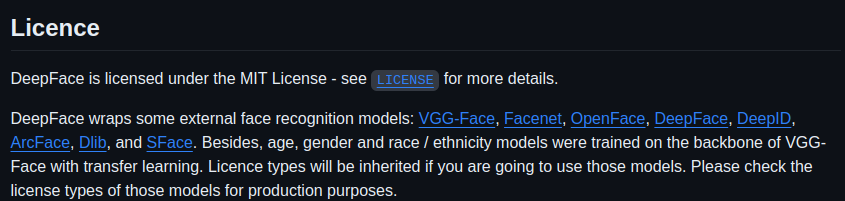

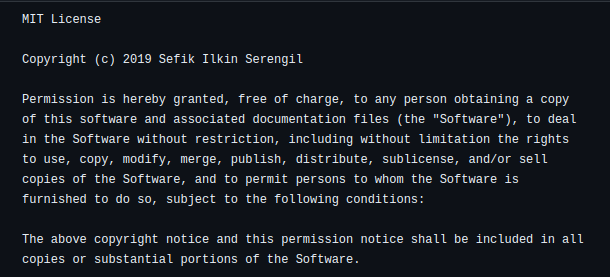